# VALUE AT RISK FOR EXTREME ANALYSIS

In [60]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [61]:
dataset=pd.read_csv('CAC40.csv')


In [62]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Price'] = dataset['Price'].apply(lambda x : float(x.replace(',','')))

In [63]:
dataset.head()

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month
0,2024-03-28,8205.81,"8,216.77","8,253.59","8,205.81",63.58M,0.01%,2024,3
1,2024-03-27,8204.81,"8,186.07","8,230.38","8,174.26",49.55M,0.25%,2024,3
2,2024-03-26,8184.75,"8,160.64","8,188.53","8,136.64",54.98M,0.41%,2024,3
3,2024-03-25,8151.60,"8,147.80","8,165.95","8,101.83",45.33M,0.00%,2024,3
4,2024-03-22,8151.92,"8,149.23","8,179.32","8,129.17",50.22M,-0.34%,2024,3


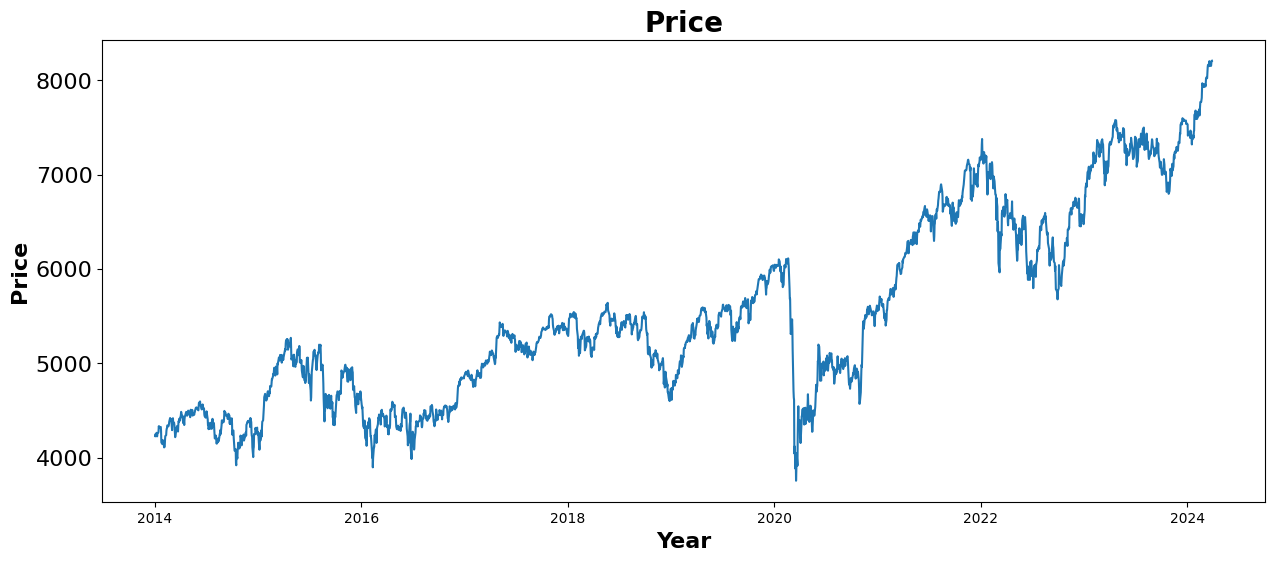

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15, 6))

# Tracer le graphique
sns.lineplot(data=dataset, x='Date', y='Price', ax=ax)

# Titre et étiquettes des axes
ax.set_title('Price', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize=16, fontdict=dict(weight='bold'))

# Ajustement de la taille des étiquettes
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=10)  # Ajuster la taille de l'étiquette de l'axe x

# Afficher le graphique
plt.show()


## Extreme quantile estimation of daily loss(Value at risk)

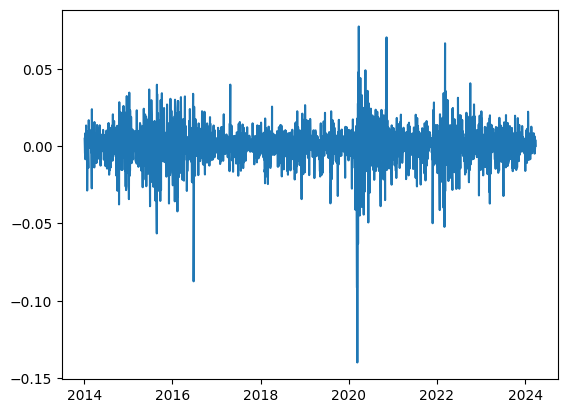

In [65]:
price = dataset['Price'].values
daily_loss = -(price[1:] - price[:-1])/price[:-1]
n = len(daily_loss)
plt.plot(dataset['Date'][:-1],daily_loss)
plt.show()

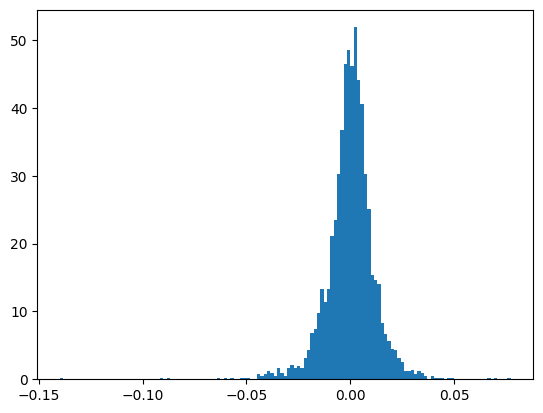

In [66]:
num_daily_loss = len(daily_loss)
plt.hist(daily_loss,bins='auto',density='True')
plt.show()

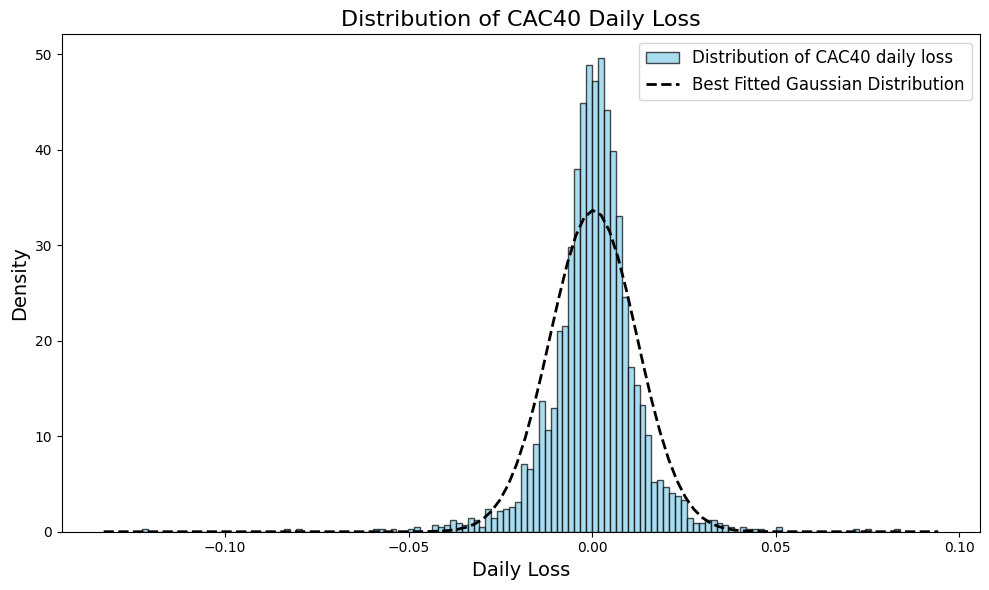

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats



daily_loss = -(price[1:] - price[:-1]) / price[1:]

plt.figure(figsize=(10, 6))  # Set figure size

# Histogram plot
plt.hist(daily_loss, bins='auto', density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Distribution of CAC40 daily loss')

# Gaussian distribution plot
daily_loss_min, daily_loss_max = plt.xlim()
x = np.linspace(daily_loss_min, daily_loss_max, 100)
daily_loss_mean = np.mean(daily_loss)
daily_loss_std = np.std(daily_loss)
p = stats.norm.pdf(x, loc=daily_loss_mean, scale=daily_loss_std)
plt.plot(x, p, 'k--', linewidth=2, label='Best Fitted Gaussian Distribution')

# Add labels and legend
plt.xlabel('Daily Loss', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of CAC40 Daily Loss', fontsize=16)
plt.legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Empirical quantile

In [68]:
daily_loss_sorted = np.sort(daily_loss)
order = int(np.ceil((1-0.05)*num_daily_loss))
VaR_emp = daily_loss_sorted[order]
VaR_emp

0.017854733165897068

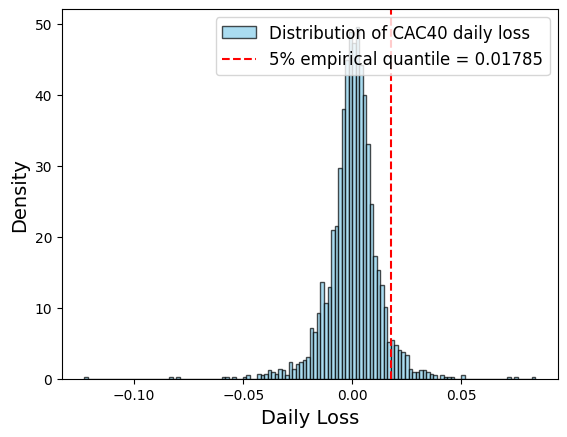

In [69]:
plt.hist(daily_loss, bins='auto', density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Distribution of CAC40 daily loss')

# Plotting vertical line for empirical quantile
plt.axvline(VaR_emp, color='red', linestyle='--', label='5% empirical quantile = ' + str(np.round(VaR_emp, 5)))

# Labeling axes
plt.xlabel('Daily Loss', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

## Pick over threshold method

In [70]:
daily_loss_sorted = np.sort(daily_loss)

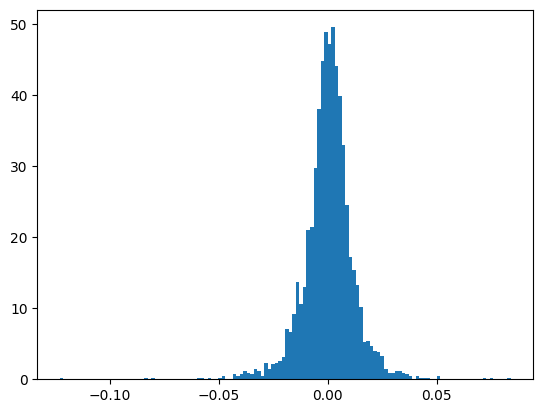

In [71]:
plt.hist(daily_loss_sorted,bins='auto',density='True')
plt.show()

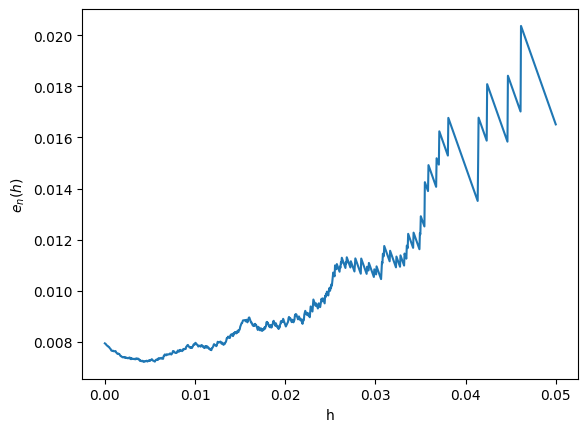

In [72]:
interval = np.linspace(0,0.05,1000)
Exceed = [np.mean(daily_loss[daily_loss>u]-u) for u in interval]
plt.plot(interval,Exceed)
plt.xlabel('h')
plt.ylabel('$e_n(h)$')
plt.show()

In [73]:
u = 0.015
X = daily_loss[daily_loss>u]-u
Nu = len(X)
Nu 

182

In [74]:
from scipy.stats import norm
from scipy import optimize

In [75]:
def f(y):
    density = ksi/beta*np.power((1+ksi/beta*y),-1/ksi - 1)
    return(density)
def minus_log_likelihood(params):
    beta,ksi= params
    likelihood = -Nu*np.log(beta) - (1/ksi +1)*np.sum(np.log(1+X*ksi/beta))
    return(-likelihood)

In [76]:
initial_guess = [0.007,0.9] 
result = optimize.minimize(minus_log_likelihood, initial_guess,bounds=[(0.0001,0.02),(0.1,5)])
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -686.0975401394453
        x: [ 7.519e-03  1.206e-01]
      nit: 8
      jac: [ 7.844e-04  4.547e-05]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

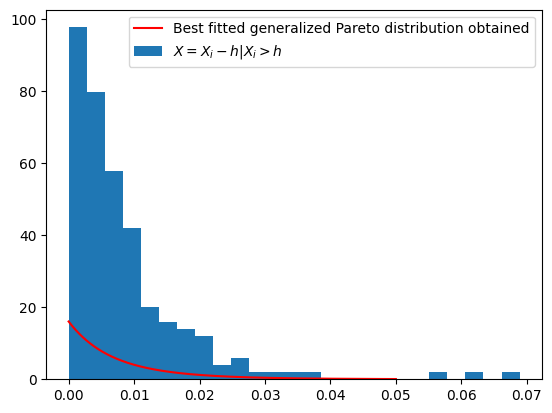

In [77]:
beta,ksi = 7.519e-03, 1.206e-01
plt.plot(interval,f(interval),color='red',label='Best fitted generalized Pareto distribution obtained' )
interval = np.linspace(0,0.1,100)
plt.hist(X,bins='auto',density='True',label = '$ X = X_i - h | X_i>h$')
plt.legend()
plt.show()

In [78]:
def F_bar(x):
    return(Nu/n*np.power(1+ksi/beta*(x-u),-1/ksi))

In [79]:
for x in np.linspace(u,u+0.01,100):
    if F_bar(x)<=0.05:
        quantile_pot = x
        break

In [80]:
Var_extreme = quantile_pot
Var_extreme

0.017525252525252524

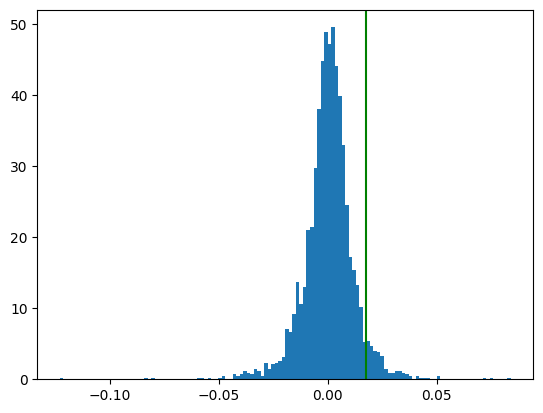

In [81]:
plt.hist(daily_loss,bins='auto',density='True')
plt.axvline(Var_extreme,color='green')
plt.show()

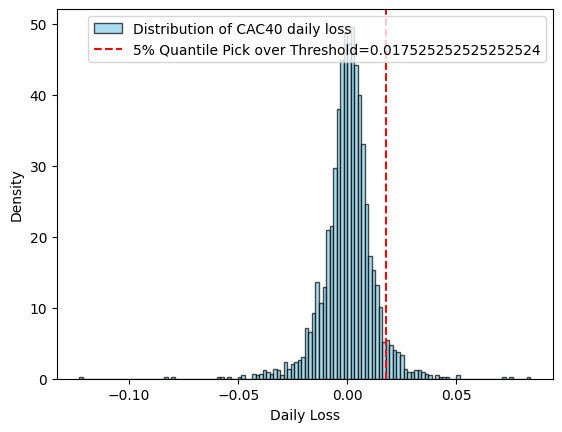

In [87]:
import matplotlib.pyplot as plt

# Plot the histogram with density=True to display a normalized histogram
plt.hist(daily_loss, bins='auto', density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Distribution of CAC40 daily loss')  # Adjust color and transparency (alpha) if needed

# Add a vertical line at Var_extreme with green color
plt.axvline(Var_extreme, color='red', linestyle='--', label=f'5% Quantile Pick over Threshold={Var_extreme}')  # Set linestyle as '--' for dashed line

# Add legend
plt.legend()

# Labeling the axes
plt.xlabel('Daily Loss')
plt.ylabel('Density')

# Show the plot
plt.show()
